## Paso 1: Cargar los datos

In [781]:
import pandas as pd

# Cargar el archivo CSV
df = pd.read_csv('start_steps_confirm.csv')

# Convertir la columna de fecha y hora a formato datetime
df['date_time'] = pd.to_datetime(df['date_time'])

# Verifica los datos
df



,client_id,visitor_id,visit_id,process_step,date_time,Variation
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test
...,...,...,...,...,...,...
291295,1574008,117364417_77840596075,528720790_71583064618_169151,confirm,2017-05-06 23:51:05,Test
291296,1574008,117364417_77840596075,528720790_71583064618_169151,step_3,2017-05-06 23:50:40,Test
291297,1574008,117364417_77840596075,528720790_71583064618_169151,step_2,2017-05-06 23:43:47,Test
291298,1574008,117364417_77840596075,528720790_71583064618_169151,step_1,2017-05-06 23:43:34,Test


#### 1. Eliminar de df clientes que tienen mas de 24 horas entre pasos (process_step)
#### 2. Calcular tiempo promedio por paso en 2 grupos (Test y Control)

In [782]:
import pandas as pd


# Paso 1: formato correcto de 'date_time'
df['date_time'] = pd.to_datetime(df['date_time'])

# Paso 2: Ordenar por 'visitor_id' y 'date_time' para calcular la diferencia entre pasos
df = df.sort_values(by=['visitor_id', 'date_time'])

# Paso 3: Calcular la diferencia de tiempo entre pasos para cada cliente
df['time_diff'] = df.groupby('visitor_id')['date_time'].diff()

# Paso 4: Filtrar clientes que tienen diferencias de más de 24 horas
# Utilizar timedelta para comparar
df = df[(df['time_diff'].isna()) | (df['time_diff'] <= pd.Timedelta(hours=24))]

# Paso 5: Eliminar las filas donde 'time_diff' tiene valores NaN (si es necesario)
df = df.dropna(subset=['time_diff'])

# Paso 6: Calcular el tiempo promedio por paso y convertir a minutos
average_time_per_step = df.groupby(['process_step', 'Variation'])['time_diff'].mean()

# Convertir a minutos
average_time_per_step_in_minutes = average_time_per_step.dt.total_seconds() / 60

# Verificar si el índice tiene la estructura correcta
if isinstance(average_time_per_step_in_minutes.index, pd.MultiIndex):
    # Desapilar para crear un DataFrame
    average_time_per_step_in_minutes = average_time_per_step_in_minutes.unstack(level='Variation')
else:
    print("El índice no es un MultiIndex. Verificando estructura...")
    print(average_time_per_step_in_minutes.index)

# Crear un orden personalizado para los pasos del proceso
step_order = ['start', 'step_1', 'step_2', 'step_3', 'confirm']

# Reorganizar el índice para mantener el orden deseado
average_time_per_step_in_minutes = average_time_per_step_in_minutes.reindex(step_order)

# Mostrar resultados
print("Tiempo promedio por paso (en minutos):")
print(average_time_per_step_in_minutes.fillna(0))  # Reemplazar NaN con 0 si lo deseas

# Opcional: Comprobar si hay valores extremadamente altos o bajos
print("Resumen estadístico de tiempos promedio:")
print(average_time_per_step_in_minutes.describe())


Tiempo promedio por paso (en minutos):
Variation       Control       Test
process_step                      
start         36.436069  20.206186
step_1         1.003979   0.918497
step_2         0.678549   0.933864
step_3         1.596682   1.758716
confirm        5.942645  18.192333
Resumen estadístico de tiempos promedio:
Variation    Control       Test
count       5.000000   5.000000
mean        9.131585   8.401919
std        15.410960   9.888105
min         0.678549   0.918497
25%         1.003979   0.933864
50%         1.596682   1.758716
75%         5.942645  18.192333
max        36.436069  20.206186


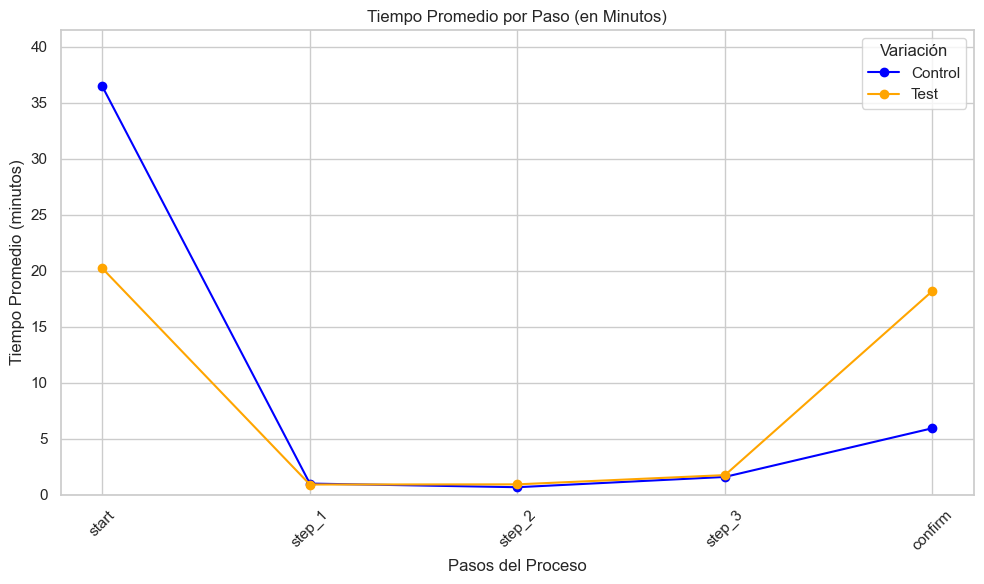

In [783]:
# Crear un gráfico de líneas
plt.figure(figsize=(10, 6))
plt.plot(average_time_per_step_df['process_step'], average_time_per_step_df['Control'], marker='o', label='Control', color='blue')
plt.plot(average_time_per_step_df['process_step'], average_time_per_step_df['Test'], marker='o', label='Test', color='orange')

# Configuración del gráfico
plt.title('Tiempo Promedio por Paso (en Minutos)')
plt.ylabel('Tiempo Promedio (minutos)')
plt.xlabel('Pasos del Proceso')
plt.xticks(rotation=45)
plt.legend(title='Variación')
plt.ylim(0, average_time_per_step_in_minutes.max().max() + 5)  # Ajustar el límite superior para la claridad

# Mostrar el gráfico
plt.tight_layout()
plt.show()


### Total de clientes únicos 

In [784]:
# Contar el número total de clientes únicos en el DataFrame filtrado
total_clientes_unicos = df['client_id'].nunique()

# Imprimir el resultado
print(f"Total de clientes únicos en el DataFrame filtrado: {total_clientes_unicos}")


Total de clientes únicos en el DataFrame filtrado: 42111


## Cantidad total de clientes, distribucion (Test/Control), cantidad de compras por grupos basada en process_step

In [785]:
import pandas as pd

# Paso 1: Obtener la cantidad total de clientes y su distribución
total_clientes = df['client_id'].nunique()

# Cantidad de clientes en el grupo Test y Control
clientes_test = df[df['Variation'] == 'Test']['client_id'].nunique()
clientes_control = df[df['Variation'] == 'Control']['client_id'].nunique()

# Calcular los porcentajes de clientes en Test y Control
porcentaje_test = (clientes_test / total_clientes) * 100 if total_clientes > 0 else 0
porcentaje_control = (clientes_control / total_clientes) * 100 if total_clientes > 0 else 0

# Paso 2: Filtrar las compras
compras = df[df['process_step'] == 'confirm']

# Cantidad de compras en Test y Control
compras_test = compras[compras['Variation'] == 'Test']['client_id'].nunique()
compras_control = compras[compras['Variation'] == 'Control']['client_id'].nunique()

# Calcular los porcentajes de compras en Test y Control
porcentaje_compras_test = (compras_test / clientes_test) * 100 if clientes_test > 0 else 0
porcentaje_compras_control = (compras_control / clientes_control) * 100 if clientes_control > 0 else 0

# Imprimir resultados
print(f"Total de clientes: {total_clientes}")
print(f"Clientes en Test: {clientes_test} ({porcentaje_test:.2f}%)")
print(f"Clientes en Control: {clientes_control} ({porcentaje_control:.2f}%)\n")

print(f"Compras en Test: {compras_test} ({porcentaje_compras_test:.2f}%)")
print(f"Compras en Control: {compras_control} ({porcentaje_compras_control:.2f}%)")


Total de clientes: 42111
Clientes en Test: 22888 (54.35%)
Clientes en Control: 19223 (45.65%)

Compras en Test: 16478 (71.99%)
Compras en Control: 13798 (71.78%)


C:\Users\Usuario\AppData\Local\Temp\ipykernel_135836\722938947.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Grupo', y='Cantidad de Clientes', data=clientes_df, palette='viridis')
C:\Users\Usuario\AppData\Local\Temp\ipykernel_135836\722938947.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Grupo', y='Cantidad de Compras', data=compras_df, palette='viridis')


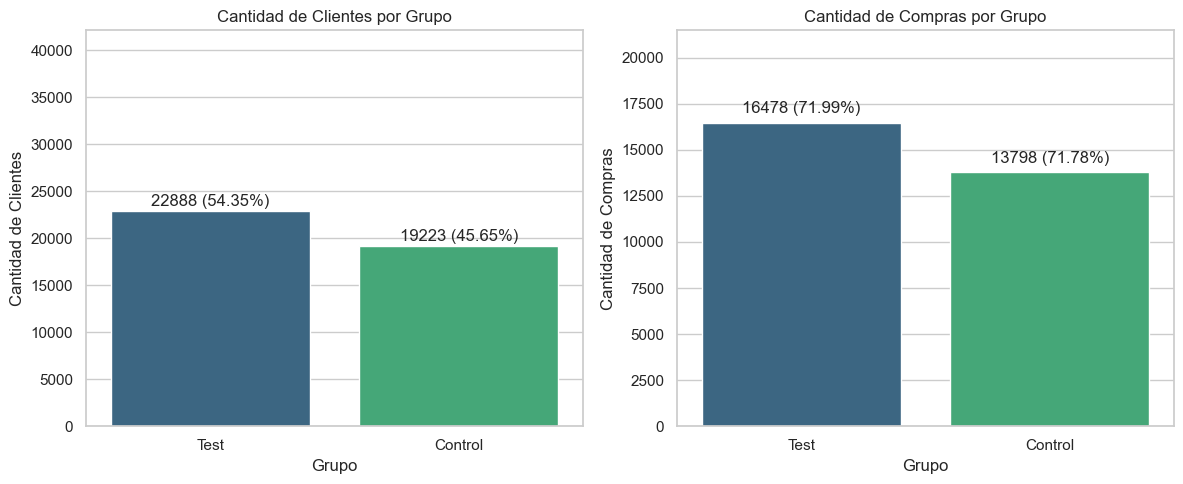

In [786]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Datos obtenidos de tu análisis
total_clientes = 42111
clientes_test = 22888
clientes_control = 19223
compras_test = 16478
compras_control = 13798

# Paso 1: Crear un DataFrame para los clientes
clientes_data = {
    'Grupo': ['Test', 'Control'],
    'Cantidad de Clientes': [clientes_test, clientes_control],
    'Porcentaje': [porcentaje_test, porcentaje_control]
}

clientes_df = pd.DataFrame(clientes_data)

# Paso 2: Crear un DataFrame para las compras
compras_data = {
    'Grupo': ['Test', 'Control'],
    'Cantidad de Compras': [compras_test, compras_control],
    'Porcentaje de Compras': [porcentaje_compras_test, porcentaje_compras_control]
}

compras_df = pd.DataFrame(compras_data)

# Gráfico de barras para la cantidad de clientes
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x='Grupo', y='Cantidad de Clientes', data=clientes_df, palette='viridis')
plt.title('Cantidad de Clientes por Grupo')
plt.ylabel('Cantidad de Clientes')
plt.ylim(0, total_clientes)
for index, value in enumerate(clientes_df['Cantidad de Clientes']):
    plt.text(index, value + 500, f'{value} ({clientes_df["Porcentaje"].iloc[index]:.2f}%)', ha='center')

# Gráfico de barras para la cantidad de compras
plt.subplot(1, 2, 2)
sns.barplot(x='Grupo', y='Cantidad de Compras', data=compras_df, palette='viridis')
plt.title('Cantidad de Compras por Grupo')
plt.ylabel('Cantidad de Compras')
plt.ylim(0, max(compras_df['Cantidad de Compras']) + 5000)
for index, value in enumerate(compras_df['Cantidad de Compras']):
    plt.text(index, value + 500, f'{value} ({compras_df["Porcentaje de Compras"].iloc[index]:.2f}%)', ha='center')

plt.tight_layout()
plt.show()


In [787]:
import scipy.stats as stats
import numpy as np

# Crear tabla de contingencia (valores observados)
# [ [Compras en Test, No Compras en Test],
#   [Compras en Control, No Compras en Control] ]
tabla_contingencia = np.array([[compras_test, clientes_test - compras_test],
                               [compras_control, clientes_control - compras_control]])

# Realizar el test de chi-cuadrado
chi2, p_valor, dof, esperados = stats.chi2_contingency(tabla_contingencia)

# Mostrar resultados
print(f"Valor de chi-cuadrado: {chi2}")
print(f"p-valor: {p_valor}")

# Interpretar el p-valor
alpha = 0.05
if p_valor < alpha:
    print("Rechazamos la hipótesis nula. Hay una diferencia significativa entre los grupos.")
else:
    print("No podemos rechazar la hipótesis nula. No hay suficiente evidencia de una diferencia significativa.")


Valor de chi-cuadrado: 0.22949812255840213
p-valor: 0.6318962129681145
No podemos rechazar la hipótesis nula. No hay suficiente evidencia de una diferencia significativa.


# Cálculo de KPIs

## Tasa de Finalización / Calculamos la tasa de finalización para cada grupo (Control y Test).

In [788]:
# Contar el total de usuarios únicos que llegan al paso de confirmación
completion_control = df[(df['Variation'] == 'Control') & 
                        (df['process_step'] == 'confirm')]['visitor_id'].nunique()

completion_test = df[(df['Variation'] == 'Test') & 
                     (df['process_step'] == 'confirm')]['visitor_id'].nunique()

# Contar el total de usuarios únicos, excluyendo los que deben ser excluidos
total_users_control = df[df['Variation'] == 'Control']['visitor_id'].nunique()
total_users_test = df[df['Variation'] == 'Test']['visitor_id'].nunique()

# Tasa de finalización
completion_rate_control = (completion_control / total_users_control * 100) if total_users_control > 0 else 0
completion_rate_test = (completion_test / total_users_test * 100) if total_users_test > 0 else 0

# Mostrar resultados
print(f"Tasa de finalización (Control): {completion_rate_control:.2f}%")
print(f"Tasa de finalización (Test): {completion_rate_test:.2f}%")




Tasa de finalización (Control): 66.02%
Tasa de finalización (Test): 67.60%


C:\Users\Usuario\AppData\Local\Temp\ipykernel_135836\1823917114.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Variación', y='Tasa de Finalización (%)', data=df_visualization, palette='viridis')


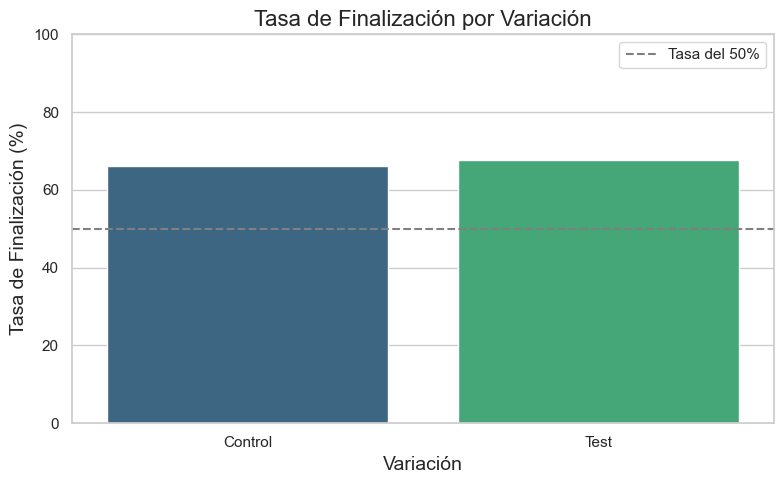

In [789]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Datos de tasa de finalización
data = {
    'Variación': ['Control', 'Test'],
    'Tasa de Finalización (%)': [66.02, 67.60]
}

# Crear un DataFrame
df_visualization = pd.DataFrame(data)

# Configurar el estilo de Seaborn
sns.set(style='whitegrid')

# Crear el gráfico de barras
plt.figure(figsize=(8, 5))
sns.barplot(x='Variación', y='Tasa de Finalización (%)', data=df_visualization, palette='viridis')

# Añadir título y etiquetas
plt.title('Tasa de Finalización por Variación', fontsize=16)
plt.xlabel('Variación', fontsize=14)
plt.ylabel('Tasa de Finalización (%)', fontsize=14)
plt.ylim(0, 100)  # Ajustar el límite del eje y
plt.axhline(y=50, color='gray', linestyle='--', label='Tasa del 50%')  # Línea de referencia
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [790]:
conversion_rate = df.groupby(['process_step', 'Variation'])['visitor_id'].nunique() / total_visitors * 100
print(conversion_rate)


process_step  Variation
confirm       Control      30.402874
              Test         36.701635
start         Control      17.986071
              Test         23.932208
step_1        Control      42.035086
              Test         50.401111
step_2        Control      38.012959
              Test         45.367391
step_3        Control      35.121435
              Test         41.951338
Name: visitor_id, dtype: float64


#### Comentarios sobre pasos
#### start: Control: 17.99% de los visitantes únicos comenzaron el proceso. / Test: 23.93% de los visitantes únicos comenzaron el proceso.
#### step_1:   Control: 42.04% llegaron al paso 1. / Test: 50.40% llegaron al paso 1.
#### step_2:   Control: 38.01% llegaron al paso 2. / Test: 45.37% llegaron al paso 2.
#### step_3:   Control: 35.12% llegaron al paso 3. / Test: 41.95% llegaron al paso 3. 
#### confirm:  Control: 30.40% de los visitantes únicos confirmaron una acción / Test: 36.70% de los visitantes únicos confirmaron una acción.

#### Análisis Comparativo
#### En general, el grupo Test muestra tasas de conversión más altas en todos los pasos en comparación con el grupo Control, lo que sugiere que las modificaciones o cambios aplicados en el grupo Test han tenido un efecto positivo en el rendimiento del proceso.
#### La mayor diferencia se observa en el paso 1, donde el Test tiene un 8.36% más de conversión que el Control.
#### La tasa de conversión en el paso de confirm también muestra una mejora notable, lo que puede indicar que los cambios realizados han llevado a más usuarios a completar la acción final.
#### Conclusiones
#### Los resultados sugieren que las modificaciones implementadas en el grupo Test están funcionando, ya que están logrando que más visitantes avancen a través del proceso y completen la acción final.
#### Estos datos pueden ser útiles para tomar decisiones sobre qué cambios mantener o ajustar en el flujo del proceso para mejorar aún más la tasa de conversión general.


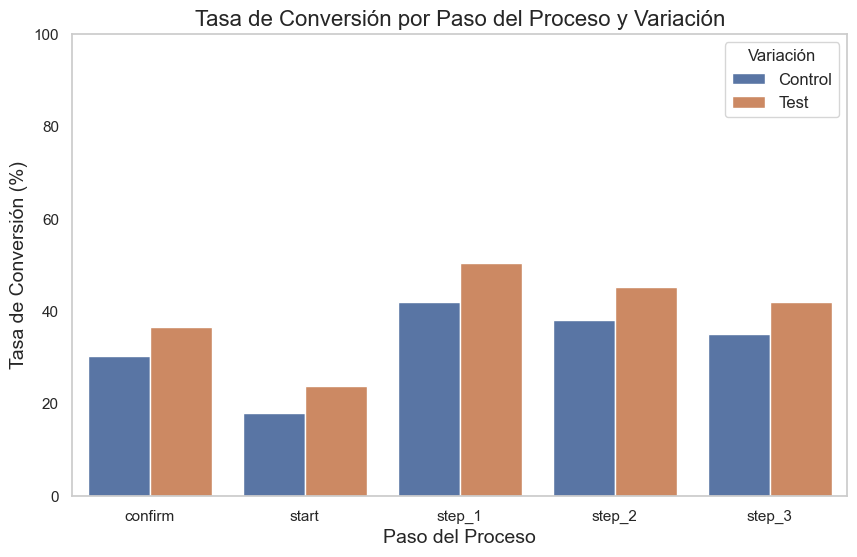

In [791]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suponiendo que ya tienes el DataFrame `conversion_rate`
# Resetear el índice para poder usar las columnas en el gráfico
conversion_rate_df = conversion_rate.reset_index()

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=conversion_rate_df, x='process_step', y='visitor_id', hue='Variation')

# Añadir títulos y etiquetas
plt.title('Tasa de Conversión por Paso del Proceso y Variación', fontsize=16)
plt.xlabel('Paso del Proceso', fontsize=14)
plt.ylabel('Tasa de Conversión (%)', fontsize=14)
plt.ylim(0, 100)  # Para que el eje y vaya de 0 a 100
plt.axhline(0, color='grey', linewidth=0.8)  # Línea en y=0 para referencia
plt.legend(title='Variación', fontsize=12)
plt.grid(axis='y')

# Mostrar el gráfico
plt.show()


In [792]:
df['cohort'] = df['date_time'].dt.to_period('M')  # Cohorte mensual
cohort_analysis = df.groupby(['cohort', 'Variation'])['visitor_id'].nunique().unstack()
print(cohort_analysis)


Variation  Control   Test
cohort                   
2017-03       3811   5119
2017-04      11829  15082
2017-05       4165   3835
2017-06       2375   2029


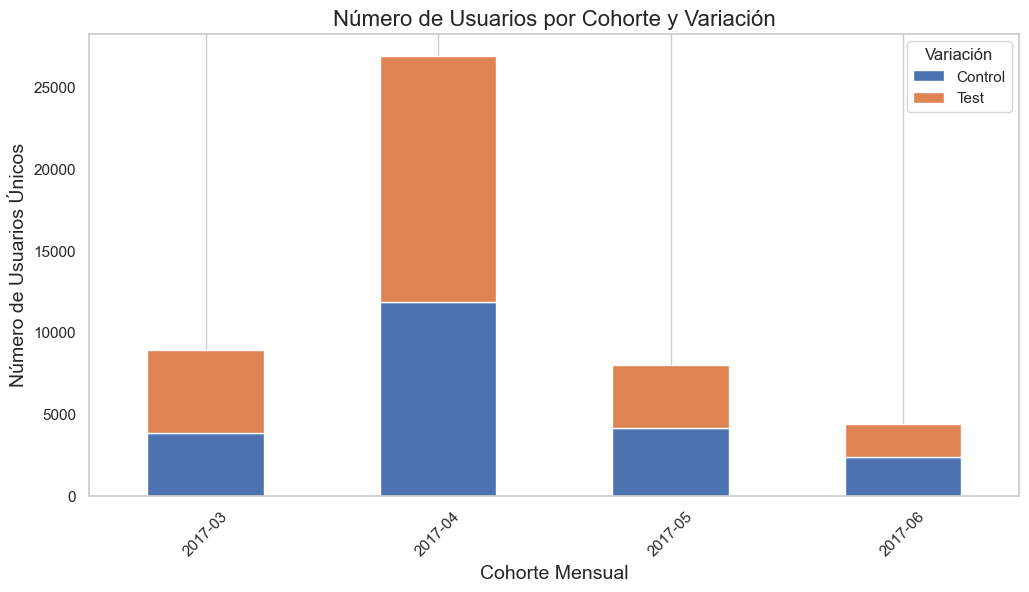

In [793]:
# Gráfico de barras apiladas
cohort_analysis.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title('Número de Usuarios por Cohorte y Variación', fontsize=16)
plt.xlabel('Cohorte Mensual', fontsize=14)
plt.ylabel('Número de Usuarios Únicos', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Variación')
plt.grid(axis='y')
plt.show()


#### Comentarios
#### El análisis de cohortes permite observar el comportamiento de diferentes grupos de usuarios (o cohortes) a lo largo del tiempo
#### Interpretación de los Resultados:

#### 2017-03: En marzo de 2017, había 3,811 usuarios en el grupo Control y 5,119 en el grupo Test.
#### 2017-04: En abril, el número de usuarios en Control aumentó a 11,829, mientras que en Test aumentó a 15,082, lo que podría indicar un interés creciente o una mejor captación de usuarios en ese mes.
#### 2017-05 y 2017-06: Los números disminuyen en ambos grupos en mayo y junio, lo que podría indicar una menor captación o retención de usuarios en esos meses.

In [794]:
# Obtener la primera visita de cada visitante
df['first_visit'] = df.groupby('visitor_id')['date_time'].transform('min')

# Identificar si el visitante es nuevo o recurrente
df['user_type'] = df.apply(lambda row: 'new' if row['date_time'] == row['first_visit'] else 'returning', axis=1)

# Análisis por segmento de usuario
user_segment_analysis = df.groupby(['user_type', 'Variation'])['visitor_id'].nunique().unstack()
print(user_segment_analysis)


Variation  Control   Test
user_type                
new          20810  24564
returning    18787  22816


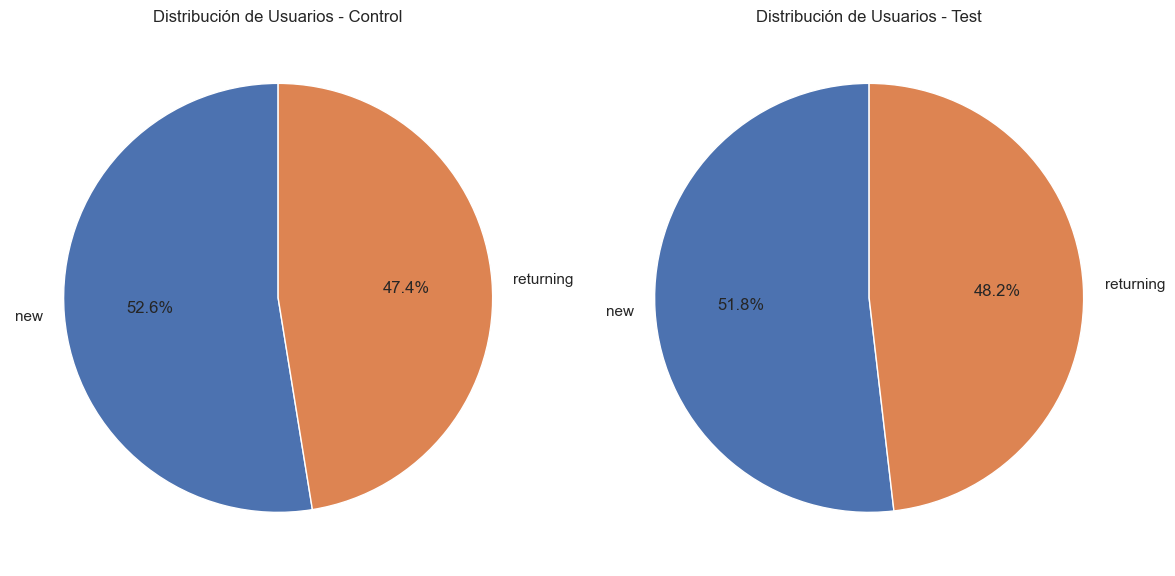

In [795]:
import pandas as pd
import matplotlib.pyplot as plt

# Simulando el DataFrame basado en tus resultados
data = {
    'user_type': ['new', 'returning'],
    'Control': [20810, 18787],
    'Test': [24564, 22816]
}
user_segment_analysis = pd.DataFrame(data)

# Configuración para el gráfico de pastel
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Crear dos subgráficos

# Gráfico de pastel para el grupo Control
axes[0].pie(user_segment_analysis['Control'], labels=user_segment_analysis['user_type'], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Distribución de Usuarios - Control')

# Gráfico de pastel para el grupo Test
axes[1].pie(user_segment_analysis['Test'], labels=user_segment_analysis['user_type'], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Distribución de Usuarios - Test')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


#### Comentarios 
#### Análisis por segmento de usuario muestra el número de visitantes únicos (visitor_id) clasificados como nuevos o recurrentes, distribuidos entre las variaciones Control y Test.
#### Nuevos Usuarios: Control: 20,810 visitantes únicos son nuevos. / Test: 24,564 visitantes únicos son nuevos.
#### Usuarios Recurrentes: Control: 18,787 visitantes únicos son recurrentes. / Test: 22,816 visitantes únicos son recurrentes.

#### Distribución de Nuevos Usuarios: Hay más nuevos usuarios en el grupo de Test en comparación con el Control, lo que podría indicar que la variación Test tiene un mejor rendimiento en atraer a nuevos visitantes.

#### Distribución de Usuarios Recurrentes: Aunque ambos grupos tienen un número considerable de usuarios recurrentes, el grupo Test también tiene más visitantes recurrentes que el Control. Esto sugiere que el Test no solo atrae nuevos usuarios, sino que también puede estar fomentando que los visitantes regresen.

### El recorrido de los visitantes a través de diferentes pasos de un proceso en función de su identificación y variación (Control o Test)

In [796]:
navigation_patterns = df.groupby(['visitor_id', 'Variation'])['process_step'].apply(lambda x: ' -> '.join(x)).reset_index()
navigation_patterns 


,visitor_id,Variation,process_step
0,100019786_4272121951,Test,step_1 -> step_2 -> step_3 -> confirm -> confirm
1,100026388_52569174348,Test,start -> step_1 -> start -> start -> step_1 ->...
2,10008560_69050398598,Control,step_1 -> step_2 -> step_2 -> step_3 -> start ...
3,100090034_17227185735,Test,step_1 -> step_2 -> start -> step_2
4,100120667_10952149000,Control,step_1 -> step_2 -> step_3 -> confirm
...,...,...,...
45523,999960535_69356103337,Test,step_1 -> step_2 -> step_3 -> confirm
45524,999986924_89514756905,Test,confirm -> confirm -> confirm -> confirm -> co...
45525,999995931_60089148022,Control,step_1 -> step_2 -> step_3 -> step_2 -> step_3...
45526,999997533_50295491521,Test,step_1 -> step_2 -> step_3 -> confirm -> confirm


## La frecuencia de cada patrón de navegación agrupado por Variation (Control o Test) y por process_step (los pasos que los visitantes han seguido).

In [797]:
pattern_counts = navigation_patterns.groupby(['Variation', 'process_step']).size().reset_index(name='count')
print(pattern_counts.sort_values(by='count', ascending=False))


     Variation                                       process_step  count
4567      Test              step_1 -> step_2 -> step_3 -> confirm   8289
1537   Control              step_1 -> step_2 -> step_3 -> confirm   7182
6      Control                                              start   1088
3223      Test                                             step_1    950
696    Control                                             step_1    941
...        ...                                                ...    ...
2084   Control  step_1 -> step_2 -> step_3 -> step_2 -> step_3...      1
2083   Control  step_1 -> step_2 -> step_3 -> step_2 -> step_3...      1
2081   Control  step_1 -> step_2 -> step_3 -> step_2 -> step_3...      1
2080   Control  step_1 -> step_2 -> step_3 -> step_2 -> step_3...      1
5411      Test  step_3 -> step_2 -> start -> step_2 -> step_2 ...      1

[5412 rows x 3 columns]


## El patrón de navegación más común para cada grupo de variación (Control y Test) en el conjunto de datos

In [798]:
most_common_patterns = navigation_patterns.groupby('Variation').agg({'process_step': lambda x: x.value_counts().idxmax()}).reset_index()
print(most_common_patterns)


  Variation                           process_step
0   Control  step_1 -> step_2 -> step_3 -> confirm
1      Test  step_1 -> step_2 -> step_3 -> confirm


In [799]:
navigation_patterns['length'] = navigation_patterns['process_step'].apply(lambda x: len(x.split(' -> ')))
length_analysis = navigation_patterns.groupby('Variation')['length'].describe()
print(length_analysis)


             count      mean       std  min  25%  50%  75%   max
Variation                                                       
Control    20894.0  4.896286  3.339529  1.0  4.0  4.0  6.0  88.0
Test       24634.0  5.245433  3.512769  1.0  4.0  4.0  6.0  77.0


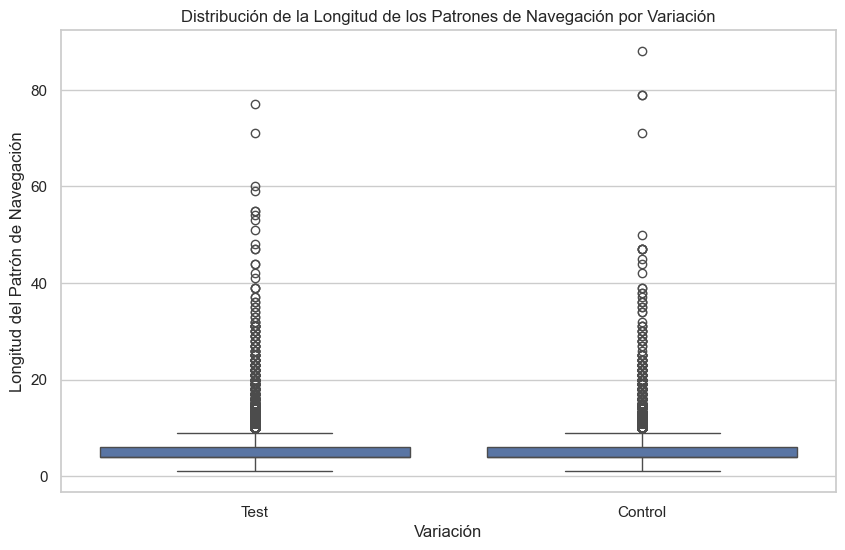

In [800]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=navigation_patterns, x='Variation', y='length')
plt.title('Distribución de la Longitud de los Patrones de Navegación por Variación')
plt.xlabel('Variación')
plt.ylabel('Longitud del Patrón de Navegación')
plt.show()


In [801]:
step_1_skippers = navigation_patterns[navigation_patterns['process_step'].str.startswith('step_1') & ~navigation_patterns['process_step'].str.contains('start')]
print(step_1_skippers)


                  visitor_id Variation  \
0       100019786_4272121951      Test   
4      100120667_10952149000   Control   
9      100206138_44165664343   Control   
13      10026984_89091519176   Control   
17     100312482_94352598047   Control   
...                      ...       ...   
45519  999825589_53806107676      Test   
45520  999874961_71184565941   Control   
45523  999960535_69356103337      Test   
45525  999995931_60089148022   Control   
45526  999997533_50295491521      Test   

                                            process_step  length  
0       step_1 -> step_2 -> step_3 -> confirm -> confirm       5  
4                  step_1 -> step_2 -> step_3 -> confirm       4  
9                  step_1 -> step_2 -> step_3 -> confirm       4  
13     step_1 -> step_2 -> step_3 -> step_3 -> confir...       6  
17                 step_1 -> step_2 -> step_3 -> confirm       4  
...                                                  ...     ...  
45519                     

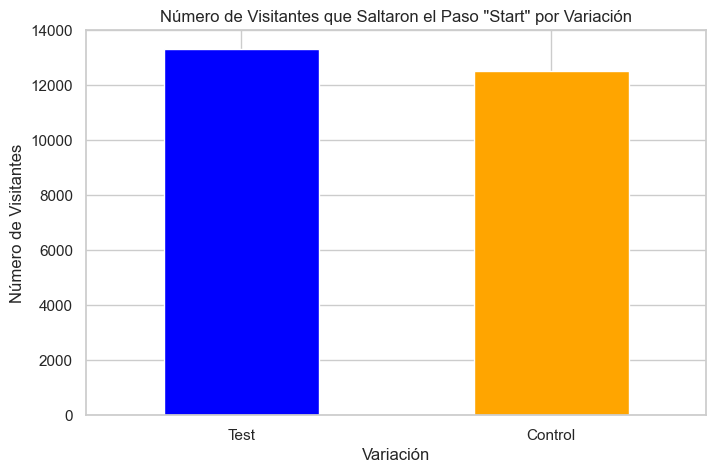

In [802]:
import matplotlib.pyplot as plt

step_1_skippers_count = step_1_skippers['Variation'].value_counts()

plt.figure(figsize=(8, 5))
step_1_skippers_count.plot(kind='bar', color=['blue', 'orange'])
plt.title('Número de Visitantes que Saltaron el Paso "Start" por Variación')
plt.xlabel('Variación')
plt.ylabel('Número de Visitantes')
plt.xticks(rotation=0)
plt.show()


In [803]:
# Contar cuántas veces aparece cada paso en cada variación
step_counts_by_variation = df.groupby(['process_step', 'Variation'])['visitor_id'].nunique().unstack()
print(step_counts_by_variation)


Variation     Control   Test
process_step                
confirm         13795  16653
start            8161  10859
step_1          19073  22869
step_2          17248  20585
step_3          15936  19035


#### Comentarios 
#### Start: Control: 8,161 / Test: 10,859
#### Análisis: Al igual que con el paso de confirmación, el grupo Test muestra un número mayor de visitantes que comienzan el proceso. Esto sugiere que las optimizaciones pueden estar funcionando para atraer más usuarios desde el principio.

#### Step 1: Control: 19,073 / Test: 22,869
#### Análisis: En este paso, también se observa una mejora en el grupo Test. Un mayor número de usuarios avanza a este paso indica un interés y una respuesta positiva hacia las modificaciones introducidas.

#### Step 2: Control: 17,248 /Test: 20,585 
#### Análisis: Nuevamente, el grupo Test supera al Control. El aumento en este paso es crucial, ya que muestra que los cambios han logrado que más usuarios continúen el proceso.

#### Step 3: Control: 15,936 / Test: 19,035
#### Análisis: Una tendencia similar se observa en el último paso, donde el grupo Test también tiene un mayor número de usuarios. Esto sugiere que los cambios no solo están aumentando el interés, sino que también están manteniendo a los usuarios comprometidos hasta el final del proceso.

#### Confirm: Control: 13,795 / Test: 16,653
#### Análisis: Hay un incremento significativo en el número de visitantes que llegan a la etapa de confirmación en el grupo Test en comparación con el grupo Control. Esto podría indicar que las modificaciones implementadas en el grupo Test están motivando a más usuarios a finalizar el proceso.

#### Comparación General
#### Aumento General en el Grupo Test: En todos los pasos analizados, el grupo Test muestra un número mayor de usuarios en comparación con el Control. Esto indica que las modificaciones implementadas en el grupo Test han tenido un impacto positivo en la experiencia del usuario y en la tasa de conversión a través del embudo.
#### Incentivos a la Continuación: La mejora en los conteos de pasos sugiere que los usuarios se sienten más motivados a seguir adelante en el proceso cuando están en el grupo Test, lo que puede ser el resultado de una interfaz más intuitiva, mejores incentivos, o cambios en el contenido que resuenan mejor con el público.

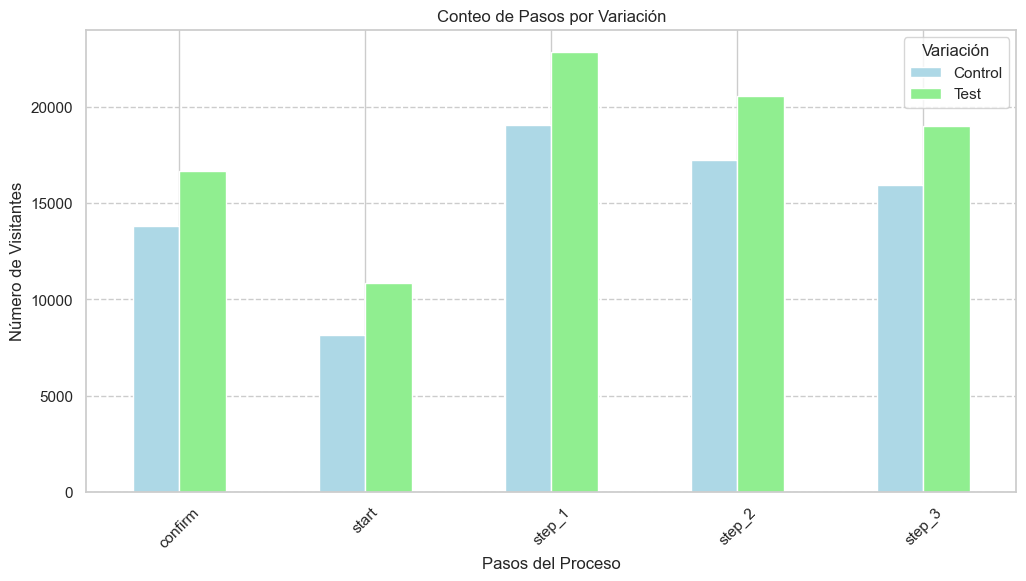

In [804]:
import matplotlib.pyplot as plt

# Crear gráfico de barras agrupadas
step_counts_by_variation.plot(kind='bar', figsize=(12, 6), color=['lightblue', 'lightgreen'])

plt.title('Conteo de Pasos por Variación')
plt.xlabel('Pasos del Proceso')
plt.ylabel('Número de Visitantes')
plt.xticks(rotation=45)
plt.legend(title='Variación')
plt.grid(axis='y', linestyle='--')
plt.show()
